# Tutorial 4: Horizontal Spatial Transcriptomics Integration

In this tutorial, we demonstrate how to analyse multiple tissue slices in horizontal integration. Here we take mouse anterior and posterior brain as example. ST data were downloaded from https://www.10xgenomics.com/. Before inputting the model, alignment algorithm was implemented to align mouse anterior and posterior brain data. 

Please note that aligned position information must be saved in adata.obsm['spatial'] before running the model.

The prepocessed data can be accessible and downloaded via https://drive.google.com/drive/folders/1jDmx8IjiGhOD__spuuhFB1fWVDJtv5CU.

In [1]:
import os
import torch
import pandas as pd
import scanpy as sc
from sklearn import metrics
import multiprocessing as mp

In [2]:
from DeepST import DeepST

In [3]:
# set random seed
random_seed = 50 
DeepST.fix_seed(random_seed)

In [4]:
# Run device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# the location of R, which is necessary for mclust algorithm. Please replace it with local R installation path
os.environ['R_HOME'] = '/scbio4/tools/R/R-4.0.3_openblas/R-4.0.3'

In [5]:
# the number of clusters
n_clusters = 26

In [6]:
# read data
file_fold = './Mouse_Brain/' #please replace it with the download path
adata = sc.read_h5ad(file_fold + 'mouse_anterior_posterior_brain_merged.h5ad')
adata.var_names_make_unique()

/home/yahui/anaconda3/envs/long/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [7]:
# preprocessing for ST data
DeepST.preprocess(adata)

# built graph
DeepST.construct_interaction(adata)
DeepST.add_contrastive_label(adata)

In [8]:
# get features
DeepST.get_feature(adata)

In [9]:
adata

AnnData object with n_obs × n_vars = 6050 × 32285
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'log1p'
    obsm: 'spatial', 'distance_matrix', 'graph_neigh', 'adj', 'label_CSL', 'feat', 'feat_a'

In [10]:
# define and train model
model = DeepST.Train(adata, device=device)
adata.obsm['emb'] = model.train()

/home/yahui/anaconda3/envs/long/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Begin to train ST data...


100%|█████████████████████████████████████████| 600/600 [00:09<00:00, 61.73it/s]

Optimization finished for ST data!


In [11]:
# clustering
from DeepST.utils import clustering
clustering(adata, n_clusters, sample='multiple', refinement=False)

R[write to console]:     __  ___________    __  _____________
   /  |/  / ____/ /   / / / / ___/_  __/
  / /|_/ / /   / /   / / / /\__ \ / /   
 / /  / / /___/ /___/ /_/ /___/ // /    
/_/  /_/\____/_____/\____//____//_/    version 5.4.9
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


<AxesSubplot:title={'center':'Mouse Anterior & Posterior Brain (Section 1)'}, xlabel='spatial1', ylabel='spatial2'>

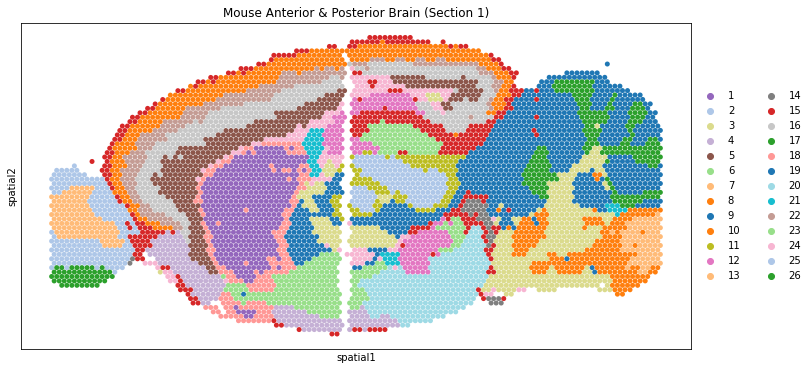

In [12]:
# plotting spatial clustering result
import matplotlib.pyplot as plt
import seaborn as sns
adata.obsm['spatial'][:,1] = -1*adata.obsm['spatial'][:,1]
rgb_values = sns.color_palette("tab20", len(adata.obs['label'].unique()))
color_fine = dict(zip(list(adata.obs['label'].unique()), rgb_values))

plt.rcParams["figure.figsize"] = (12, 6)
sc.pl.embedding(adata, basis="spatial", 
                color="label",
                s=100, 
                palette=color_fine, 
                show=False, 
                title='Mouse Anterior & Posterior Brain (Section 1)')